In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# config
# -------------------------
COCO_JOINTS = {
    0: "nose",
    1: "left_eye",
    2: "right_eye",
    3: "left_ear",
    4: "right_ear",
    5: "left_shoulder",
    6: "right_shoulder",
    7: "left_elbow",
    8: "right_elbow",
    9: "left_wrist",
    10: "right_wrist",
    11: "left_hip",
    12: "right_hip",
    13: "left_knee",
    14: "right_knee",
    15: "left_ankle",
    16: "right_ankle",
}

SKELETON = [
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 6),
    (5, 11), (6, 12),
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
]

# -------------------------
# function plot skeleton
# -------------------------
def plot_person(df, video_name, frame_id, person_id):
    data = df[
        (df["video_name"] == video_name) &
        (df["frame_id"] == frame_id) &
        (df["person_id"] == person_id)
    ]

    if data.empty:
        print("No data found")
        return

    # joint_id -> (x, y)
    joints = {
        row.joint_id: (row.x, row.y)
        for row in data.itertuples()
    }

    plt.figure(figsize=(5, 8))

    # plot joints
    for jid, (x, y) in joints.items():
        plt.scatter(x, y, c="red")
        plt.text(x + 3, y + 3, COCO_JOINTS.get(jid, jid), fontsize=8)

    # plot skeleton
    for j1, j2 in SKELETON:
        if j1 in joints and j2 in joints:
            x1, y1 = joints[j1]
            x2, y2 = joints[j2]
            plt.plot([x1, x2], [y1, y2], c="blue")

    plt.title(f"{video_name} | frame {frame_id} | person {person_id}")
    plt.gca().invert_yaxis()  # สำคัญ! เพราะ coordinate ภาพ
    plt.axis("equal")
    plt.show()


In [2]:
df = pd.read_csv("cleaned_pose_data.csv")
df.head()

,video_name,frame_id,person_id,joint_id,x,y,score
0,Hoang_Hearn,0,0,0,257.707092,629.240845,0.171782
1,Hoang_Hearn,0,0,1,260.629639,621.918457,0.159820
2,Hoang_Hearn,0,0,2,258.474365,621.872253,0.032368
3,Hoang_Hearn,0,0,3,264.950623,621.193115,0.924104
4,Hoang_Hearn,0,0,4,286.588562,618.743774,0.355051


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561272 entries, 0 to 561271
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   video_name  561272 non-null  object 
 1   frame_id    561272 non-null  int64  
 2   person_id   561272 non-null  int64  
 3   joint_id    561272 non-null  int64  
 4   x           561272 non-null  float64
 5   y           561272 non-null  float64
 6   score       561272 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 30.0+ MB


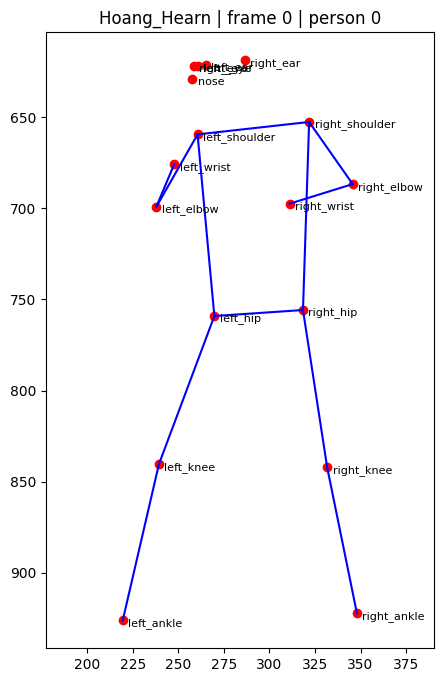

In [4]:
plot_person(
    df=df,
    video_name="Hoang_Hearn",
    frame_id=0,
    person_id=0
)

1️⃣ ST-GCN ต้องการข้อมูลหน้าตาแบบไหน

ST-GCN (ตาม paper / repo ดั้งเดิม) ใช้ input shape แบบนี้:

(N, C, T, V, M)


ความหมายคือ

ตัว	ความหมาย

N	จำนวน sample

C	จำนวน channel (ปกติ = 2 หรือ 3 → x,y,(score))

T	จำนวน frame (temporal length)

V	จำนวน joint (COCO = 17)

M	จำนวนคนใน scene (max person ต่อ frame)

👉 สำหรับข้อมูลของคุณ

V = 17

C = 2 หรือ 3

T = จำนวน frame ต่อ sample (เช่น 30, 60)

M = max person ต่อ frame (เช่น 1 หรือ 2)

2️⃣ กำหนด graph (สำคัญมาก)

2.1 Edge list

In [5]:
SKELETON = [
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 6),
    (5, 11), (6, 12),
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
]

2.2 เพิ่ม self-loop (ST-GCN ต้องใช้)

In [6]:
NUM_JOINTS = 17

self_links = [(i, i) for i in range(NUM_JOINTS)]
neighbor_links = SKELETON

edge_index = self_links + neighbor_links


(ส่วน adjacency matrix ปกติ repo ST-GCN จะ generate ให้เองจาก edge list)

3️⃣ แปลง DataFrame → Tensor ST-GCN

In [ ]:
import numpy as np

def build_stgcn_sample(
    df,
    video_name,
    person_id,
    start_frame,
    T,
    num_joints=17,
    channels=3,
):
    """
    return shape: (C, T, V, 1)
    """

    sample = np.zeros((channels, T, num_joints, 1), dtype=np.float32)

    person_df = df[
        (df.video_name == video_name) &
        (df.person_id == person_id)
    ]

    for t in range(T):
        frame_id = start_frame + t
        frame_data = person_df[person_df.frame_id == frame_id]

        for row in frame_data.itertuples():
            j = row.joint_id
            sample[0, t, j, 0] = row.x
            sample[1, t, j, 0] = row.y
            sample[2, t, j, 0] = row.score

    return sample


In [37]:
X = build_stgcn_sample(
    df=df,
    video_name="Hoang_Hearn",
    person_id=0,
    start_frame=0,
    T=30
)

print(X.shape)
# (3, 30, 17, 1)

(3, 30, 17, 1)


In [38]:
df['person_id'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [44]:
train_df = df[df['person_id'].isin([0, 1, 2])]
test_df = df[df['person_id'].isin([3, 4, 5, 6, 7, 8])]

In [40]:
last_frame_id = df.groupby('video_name')['frame_id'].max()
last_frame_id

video_name
Hoang_Hearn              721
Kum_Pa_Gun_Poong_Hork    780
Mek_Khara_Lor_Kaew       451
Narai_Kwang_Jug          810
Phra_Ram_Phang_Sorn      570
Tad_Mai_Khom_Nam         331
Name: frame_id, dtype: int64

In [41]:
int(last_frame_id['Mek_Khara_Lor_Kaew'])

451

4️⃣ สร้าง Dataset สำหรับ Train

4.1 แยก video → samples

In [11]:
def encode_video_name(video_names):
    """
    video_names: iterable (list / np.array / pd.Series)
    return:
        video_to_label: dict {video_name: int}
        label_to_video: dict {int: video_name}
    """
    unique_videos = sorted(set(video_names))

    video_to_label = {
        v: i for i, v in enumerate(unique_videos)
    }

    label_to_video = {
        i: v for v, i in video_to_label.items()
    }

    return video_to_label, label_to_video

video_names = df['video_name'].unique()
video_to_label, label_to_video = encode_video_name(video_names)

In [12]:
video_to_label

{'Hoang_Hearn': 0,
 'Kum_Pa_Gun_Poong_Hork': 1,
 'Mek_Khara_Lor_Kaew': 2,
 'Narai_Kwang_Jug': 3,
 'Phra_Ram_Phang_Sorn': 4,
 'Tad_Mai_Khom_Nam': 5}

In [13]:
label_to_video

{0: 'Hoang_Hearn',
 1: 'Kum_Pa_Gun_Poong_Hork',
 2: 'Mek_Khara_Lor_Kaew',
 3: 'Narai_Kwang_Jug',
 4: 'Phra_Ram_Phang_Sorn',
 5: 'Tad_Mai_Khom_Nam'}

In [49]:
T = 30
stride = 15

samples = []
labels = []

for video_name in train_df.video_name.unique():
    video_df = train_df[train_df.video_name == video_name]
    max_frame = video_df.frame_id.max()

    for person_id in video_df.person_id.unique():
        for start in range(0, max_frame - T + 1, stride):

            X = build_stgcn_sample(
                df=train_df,
                video_name=video_name,
                person_id=person_id,
                start_frame=start,
                T=T
            )

            samples.append(X)
            labels.append(video_to_label[video_name])

X_train = np.stack(samples)   # (N, C, T, V, 1)
y_train = np.array(labels)


In [51]:
T = 30
stride = 15

samples = []
labels = []

for video_name in test_df.video_name.unique():
    video_df = test_df[test_df.video_name == video_name]
    max_frame = video_df.frame_id.max()

    for person_id in video_df.person_id.unique():
        for start in range(0, max_frame - T + 1, stride):

            X = build_stgcn_sample(
                df=test_df,
                video_name=video_name,
                person_id=person_id,
                start_frame=start,
                T=T
            )

            samples.append(X)
            labels.append(video_to_label[video_name])

X_test = np.stack(samples)   # (N, C, T, V, 1)
y_test = np.array(labels)


5️⃣ Normalize

อย่างน้อยควรทำอย่างใดอย่างหนึ่ง:

center ด้วย hip

normalize ด้วย image size


In [52]:
def normalize_center(X):
    # hip = (11,12)
    hip_center = (X[:, :, :, 11:12, :] + X[:, :, :, 12:13, :]) / 2
    X[:, :, :, :, :] -= hip_center
    return X

X_train_norm = normalize_center(X_train)
y_train = y_train

print("     Train Sample     ")
print(f"X train shape: {X_train_norm.shape}")
print(f"y train shape: {y_train.shape}")

print("="*70)
print("     Test Sample     ")
X_test_norm = normalize_center(X_test)
y_test = y_test

print(f"X test shape: {X_test_norm.shape}")
print(f"y test shape: {y_test.shape}")

     Train Sample     
X train shape: (714, 3, 30, 17, 1)
y train shape: (714,)
     Test Sample     
X test shape: (1428, 3, 30, 17, 1)
y test shape: (1428,)


In [53]:
NUM_JOINTS = 17

SKELETON = [
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 6),
    (5, 11), (6, 12),
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
]

self_link = [(i, i) for i in range(NUM_JOINTS)]
outward = SKELETON
inward = [(j, i) for (i, j) in outward]

import numpy as np

def edge2mat(edge, num_node):
    A = np.zeros((num_node, num_node), dtype=np.float32)
    for i, j in edge:
        A[j, i] = 1
    return A

A_self = edge2mat(self_link, NUM_JOINTS)
A_in   = edge2mat(inward, NUM_JOINTS)
A_out  = edge2mat(outward, NUM_JOINTS)

A = np.stack([A_self, A_in, A_out])  # shape: (3, 17, 17)
print(f"Adjacency matrix test shape: {A.shape}")

Adjacency matrix test shape: (3, 17, 17)


In [55]:
def normalize_adjacency(A):
    """
    A: (V, V)
    return: (V, V)
    """
    Dl = np.sum(A, axis=0)          # (V,)
    Dn = np.zeros((A.shape[0], A.shape[0]), dtype=np.float32)

    for i in range(A.shape[0]):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-1)

    return A @ Dn

A_norm = np.stack([
    normalize_adjacency(A_self),
    normalize_adjacency(A_in),
    normalize_adjacency(A_out),
])

print(f"Adjacency matrix test shape: {A_norm.shape}") # (3, 17, 17)

Adjacency matrix test shape: (3, 17, 17)


In [56]:
import torch

save_dict = {
    "X_train": torch.from_numpy(X_train_norm).float(),
    "y_train": torch.from_numpy(y_train).long(),
    "X_test":  torch.from_numpy(X_test_norm).float(),
    "y_test":  torch.from_numpy(y_test).long(),
    "graph":   torch.from_numpy(A).float(),
}

torch.save(save_dict, "stgcn_dataset.pt")

6️⃣ สรุป pipeline ทั้งหมด

DataFrame

   ↓

group by video / frame / person

   ↓

(C, T, V, M) tensor

   ↓

normalize

   ↓
   
ST-GCN